# Homework - Neural networks - Part B (45 points)
## Gradient descent for simple two and three layer models

by *Brenden Lake* and *Todd Gureckis*  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/  

<div class="alert alert-danger" role="alert">
This homework is due before midnight on Monday, Feb. 14, 2022.
</div>

The first part of this assignment implements the gradient descent algorithm for a simple artificial neuron. The second part implements backpropagation for a simple network with one hidden unit.

In the first part, the neuron will learn to compute logical OR. The neuron model and logical OR are shown below, for inputs $x_0$ and $x_1$ and target output $y$.

<img src="images/nn_OR.jpeg" style="width: 350px;"/>

This assignment requires some basic PyTorch knowledge. You can review your notes from lab and also two basic [PyTorch tutorials](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html), "What is PyTorch?" and "Autograd", which should have the basics you need.

In [1]:
!pip install torch

In [2]:
# Import libraries
from __future__ import print_function
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

Let's create `torch.tensor` objects for representing the data matrix `D` with targets `Y_or` (for the logical OR function). Each row of `D` is a different data point.

In [3]:
# Data
D = np.zeros((4,2),dtype=float)
D[0,:] = [0.,0.]
D[1,:] = [0.,1.]
D[2,:] = [1.,0.]
D[3,:] = [1.,1.]
D = torch.tensor(D,dtype=torch.float)
Y_or = torch.tensor([0.,1.,1.,1.])
N = D.shape[0] # number of input patterns

The artificial neuron operates as follows. Given an input vector $x$, the net input ($\textbf{net}$) to the neuron is computed as follows

$$ \textbf{net} = \sum_i x_i w_i + b,$$

for weights $w_i$ and bias $b$. The activation function $g(\textbf{net})$ is the logistic function

$$ g(\textbf{net}) = \frac{1}{1+e^{-\textbf{net}}},$$

which is used to compute the predicted output $\hat{y} = g(\textbf{net})$. Finally, the loss (squared error) for a particular pattern $x$ is defined as 

$$ E(w,b) = (\hat{y}-y)^2,$$

where the target output is $y$. **Your main task is to manually compute the gradients of the loss $E$ with respect to the neuron parameters:**

$$\frac{\partial E(w,b)}{\partial w}, \frac{\partial E(w,b)}{\partial b}.$$

By manually, we mean to program the gradient computation directly, using the formulas discussed in class. This is in contrast to using PyTorch's `autograd` (Automatric differentiation) that computes the gradient automatically, as discussed in class, lab, and in the PyTorch tutorial (e.g., `loss.backward()`). First, let's write the activation function and the loss in PyTorch. 

In [4]:
def g_logistic(net):
    return 1. / (1.+torch.exp(-net))

def loss(yhat,y):
    return (yhat-y)**2

Next, we'll also write two functions for examining the internal operations of the neuron, and the gradients of its parameters.

In [5]:
def print_forward(x,yhat,y):
    # Examine network's prediction for input x
    print(' Input: ',end='')
    print(x.numpy())
    print(' Output: ' + str(round(yhat.item(),3)))
    print(' Target: ' + str(y.item()))

def print_grad(grad_w,grad_b):
    # Examine gradients
    print('  d_loss / d_w = ',end='')
    print(grad_w)
    print('  d_loss / d_b = ',end='')
    print(grad_b)

Now let's dive in and begin the implementation of stochastic gradient descent. We'll initialize our parameters $w$ and $b$ randomly, and proceed through a series of epochs of training. Each epoch involves visiting the four training patterns in random order, and updating the parameters after each presentation of an input pattern.



<div class="alert alert-success" role="alert">
<h3> Problem 1 (10 points) </h3>
<br>
In the code below, fill in code to manually compute the gradient in closed form.
    <ul>
        <li>See lecture slides for the equation for the gradient for the weights w.</li>
        <li>Derive (or reason) to get the equation for the gradient for bias b.</li>
    </ul>
</div>

<div class="alert alert-success" role="alert">
<h3> Problem 2 (5 points) </h3>
<br>
In the code below, fill in code for the weight and bias update rule for gradient descent.
</div>

After completing the code, run it to compare **your gradients** with the **ground-truth computed by PyTorch.** (There may be small differences that you shouldn't worry about, e.g. within 1e-6). Also, you can check the neuron's performance at the end of training.

Compute the gradient manually
 Input: [1. 0.]
 Output: 0.749
 Target: 1.0
  d_loss / d_w = [-0.09459364 -0.        ]
  d_loss / d_b = [-0.09459364]
Compute the gradient using PyTorch .backward()
  d_loss / d_w = [-0.09459364 -0.        ]
  d_loss / d_b = [-0.09459364]

Compute the gradient manually
 Input: [0. 0.]
 Output: 0.748
 Target: 0.0
  d_loss / d_w = [0. 0.]
  d_loss / d_b = [0.28207907]
Compute the gradient using PyTorch .backward()
  d_loss / d_w = [0. 0.]
  d_loss / d_b = [0.28207907]

Compute the gradient manually
 Input: [1. 1.]
 Output: 0.862
 Target: 1.0
  d_loss / d_w = [-0.0330044 -0.0330044]
  d_loss / d_b = [-0.0330044]
Compute the gradient using PyTorch .backward()
  d_loss / d_w = [-0.0330044 -0.0330044]
  d_loss / d_b = [-0.0330044]

Compute the gradient manually
 Input: [0. 1.]
 Output: 0.86
 Target: 1.0
  d_loss / d_w = [-0.         -0.03357954]
  d_loss / d_b = [-0.03357954]
Compute the gradient using PyTorch .backward()
  d_loss / d_w = [ 0.         -0.0335795

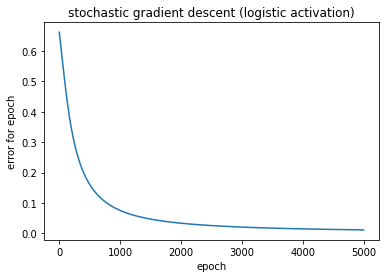

In [6]:
# Initialize parameters
#     Although you will implement gradient descent manually, let's set requires_grad=True
#     anyway so PyTorch will track the gradient too, and we can compare your gradient with PyTorch's.
w = torch.randn(2) # [size 2] tensor
b = torch.randn(1) # [size 1] tensor
w.requires_grad = True
b.requires_grad = True

alpha = 0.05 # learning rate
nepochs = 5000 # number of epochs

track_error = []
verbose = True
for e in range(nepochs): # for each epoch
    error_epoch = 0. # sum loss across the epoch
    perm = np.random.permutation(N)
    for p in perm: # visit data points in random order
        x = D[p,:] # input pattern
        
        # compute output of neuron
        net = torch.dot(x,w)+b
        yhat = g_logistic(net)
        
        # compute loss
        y = Y_or[p]
        myloss = loss(yhat,y)
        error_epoch += myloss.item()
        
        # print output if this is the last epoch
        if (e == nepochs-1):
            print("Final result:")
            print_forward(x,yhat,y)
            print("")

        # Compute the gradient manually
        if verbose:
            print('Compute the gradient manually')
            print_forward(x,yhat,y)
        with torch.no_grad():
            # TODO : YOUR GRADIENT CODE GOES HERE
            #  two lines of the form
            #    w_grad = ...    ([size 2] PyTorch tensor)
            #    b_grad = ...    ([size 1] PyTorch tensor)
            #  make sure to inclose your code in the "with torch.no_grad()" wrapper,
            #   otherwise PyTorch will try to track the "gradient" of the gradient computation, which we don't want.         
            
            # Part 1
            w_grad = 2 * (yhat - y) * g_logistic(net) * (1 - g_logistic(net)) * x
            b_grad = 2 * (yhat - y) * g_logistic(net) * (1 - g_logistic(net)) * 1
            
            #raise Exception('Replace with your code.')                      
        if verbose: print_grad(w_grad.numpy(),b_grad.numpy())

        # Compute the gradient with PyTorch and compre with manual values
        if verbose: print('Compute the gradient using PyTorch .backward()')
        myloss.backward()
        if verbose:
            print_grad(w.grad.numpy(),b.grad.numpy())
            print("")
        w.grad.zero_() # clear PyTorch's gradient
        b.grad.zero_()
        
        # Parameter update with gradient descent
        with torch.no_grad():
            # TODO : YOUR PARAMETER UPDATE CODE GOES HERE
            #  two lines of the form:
            w -=   alpha * w_grad
            b -=   alpha * b_grad
            # raise Exception('Replace with your code.')
            
    if verbose==True: verbose=False
    track_error.append(error_epoch)
    if e % 50 == 0:
        print("epoch " + str(e) + "; error=" +str(round(error_epoch,3)))
    
# track output of gradient descent
plt.figure()
plt.clf()
plt.plot(track_error)
plt.title('stochastic gradient descent (logistic activation)')
plt.ylabel('error for epoch')
plt.xlabel('epoch')
plt.show()

Now let's change the activation function to "tanh" from the "logistic" function, such that $g(\textbf{net}) = \tanh(\textbf{net})$. Here is an implementation of tanh.

In [7]:
def g_tanh(x):
    return (torch.exp(x) - torch.exp(-x))/(torch.exp(x) + torch.exp(-x))

The derivative of the tanh function is as follows:

$$\frac{\partial g(\textbf{net})}{\partial \textbf{net}}= \frac{\partial \tanh(\textbf{net})}{\partial \textbf{net}} = 1.0 - (\tanh(\textbf{net}))^2$$

<div class="alert alert-success" role="alert">
<h3> Problem 3 (5 points) </h3>
<br>
Just as before, fill in the missing code fragments for implementing gradient descent. This time we are using the tanh activation function. Be sure to change your gradient calculation to reflect the new activation function.
</div>

Compute the gradient manually
 Input: [1. 1.]
 Output: 0.999
 Target: 1.0
  d_loss / d_w = [-1.9593153e-06 -1.9593153e-06]
  d_loss / d_b = [-1.9593153e-06]
Compute the gradient using PyTorch .backward()
  d_loss / d_w = [-1.9593863e-06 -1.9593863e-06]
  d_loss / d_b = [-1.9593863e-06]

Compute the gradient manually
 Input: [0. 0.]
 Output: 0.76
 Target: 0.0
  d_loss / d_w = [0. 0.]
  d_loss / d_b = [0.6414557]
Compute the gradient using PyTorch .backward()
  d_loss / d_w = [0. 0.]
  d_loss / d_b = [0.64145565]

Compute the gradient manually
 Input: [1. 0.]
 Output: 0.949
 Target: 1.0
  d_loss / d_w = [-0.01004184 -0.        ]
  d_loss / d_b = [-0.01004184]
Compute the gradient using PyTorch .backward()
  d_loss / d_w = [-0.01004184  0.        ]
  d_loss / d_b = [-0.01004184]

Compute the gradient manually
 Input: [0. 1.]
 Output: 0.996
 Target: 1.0
  d_loss / d_w = [-0.0000000e+00 -6.8710564e-05]
  d_loss / d_b = [-6.8710564e-05]
Compute the gradient using PyTorch .backward()
  d_loss

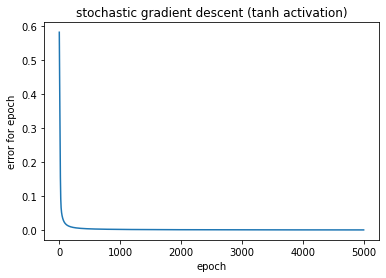

In [8]:
# Initialize parameters
#     Although you will implement gradient descent manually, let's set requires_grad=True
#     anyway so PyTorch will track the gradient too, and we can compare your gradient with PyTorch's.
w = torch.randn(2) # [size 2] tensor
b = torch.randn(1) # [size 1] tensor
w.requires_grad = True
b.requires_grad = True

alpha = 0.05 # learning rate
nepochs = 5000 # number of epochs

track_error = []
verbose = True
for e in range(nepochs): # for each epoch
    error_epoch = 0. # sum loss across the epoch
    perm = np.random.permutation(N)
    for p in perm: # visit data points in random order
        x = D[p,:] # input pattern
        
        # compute output of neuron
        net = torch.dot(x,w)+b
        yhat = g_tanh(net)
        
        # compute loss
        y = Y_or[p]
        myloss = loss(yhat,y)
        error_epoch += myloss.item()
        
        # print output if this is the last epoch
        if (e == nepochs-1):
            print("Final result:")
            print_forward(x,yhat,y)
            print("")

        # Compute the gradient manually
        if verbose:
            print('Compute the gradient manually')
            print_forward(x,yhat,y)
        with torch.no_grad():
            # TODO : YOUR GRADIENT CODE GOES HERE
            #  two lines of the form
            #    w_grad = ...    ([size 2] PyTorch tensor)
            #    b_grad = ...    ([size 1] PyTorch tensor)
            w_grad = 2 * (yhat - y) * (1 - g_tanh(net)**2) * x
            b_grad = 2 * (yhat - y) * (1 - g_tanh(net)**2) * 1
            #  make sure to inclose your code in the "with torch.no_grad()" wrapper,
            #   otherwise PyTorch will try to track the "gradient" of the graident computation, which we don't want.
            #raise Exception('Replace with your code.')                       
        if verbose: print_grad(w_grad.numpy(),b_grad.numpy())

        # Compute the gradient with PyTorch and compre with manual values
        if verbose: print('Compute the gradient using PyTorch .backward()')
        myloss.backward()
        if verbose:
            print_grad(w.grad.numpy(),b.grad.numpy())
            print("")
        w.grad.zero_() # clear PyTorch's gradient
        b.grad.zero_()
        
        # Parameter update with gradient descent
        with torch.no_grad():
            # TODO : YOUR PARAMETER UPDATE CODE GOES HERE
            #  two lines of the form:
            w -=   alpha * w_grad
            b -=   alpha * b_grad
            # raise Exception('Replace with your code.')
            
    if verbose==True: verbose=False
    track_error.append(error_epoch)
    if e % 50 == 0:
        print("epoch " + str(e) + "; error=" +str(round(error_epoch,3)))
    
# track output of gradient descent
plt.figure()
plt.clf()
plt.plot(track_error)
plt.title('stochastic gradient descent (tanh activation)')
plt.ylabel('error for epoch')
plt.xlabel('epoch')
plt.show()

In the next part, we have a simple multi-layer network with two input neurons, one hidden neuron, and one output neuron. Both the hidden and output unit should use the logistic activation function. We will learn to compute logical XOR. The network and logical XOR are shown below, for inputs $x_0$ and $x_1$ and target output $y$.

<img src="images/nn_XOR.jpeg" style="width: 500px;"/>

<div class="alert alert-success" role="alert">
<h3> Problem 4 (15 points) </h3>
<br>
You will implement backpropagation for this simple network. In the code below, you have several parts to fill in. First, define the forward pass to compute the output `yhat` from the input `x`. Second, fill in code to manually compute the gradients for all five weights w and two biases b in closed form. Third, fill in the code for updating the biases and weights.
</div>

After completing the code, run it to compare **your gradients** with the **ground-truth computed by PyTorch.** (There may be small differences that you shouldn't worry about, e.g. within 1e-6). Also, you can check the network's performance at the end of training.

Compute the gradient manually
 Input: [0. 1.]
 Output: 0.301
 Target: 1.0
 Grad for w_34 and b_0
  d_loss / d_w = [0.         0.05744437]
  d_loss / d_b = [0.05744437]
 Grad for w_012 and b_1
  d_loss / d_w = [-0.         -0.29416236 -0.21670735]
  d_loss / d_b = [-0.29416236]

Compute the gradient using PyTorch .backward()
 Grad for w_34 and b_0
  d_loss / d_w = [0.         0.05744436]
  d_loss / d_b = [0.05744436]
 Grad for w_012 and b_1
  d_loss / d_w = [-0.         -0.29416233 -0.21670732]
  d_loss / d_b = [-0.29416233]

Compute the gradient manually
 Input: [1. 1.]
 Output: 0.208
 Target: 0.0
 Grad for w_34 and b_0
  d_loss / d_w = [-0.00826398 -0.00826398]
  d_loss / d_b = [-0.00826398]
 Grad for w_012 and b_1
  d_loss / d_w = [0.06858362 0.06858362 0.05892545]
  d_loss / d_b = [0.06858362]

Compute the gradient using PyTorch .backward()
 Grad for w_34 and b_0
  d_loss / d_w = [-0.00826398 -0.00826398]
  d_loss / d_b = [-0.00826398]
 Grad for w_012 and b_1
  d_loss / d_w = [0.068

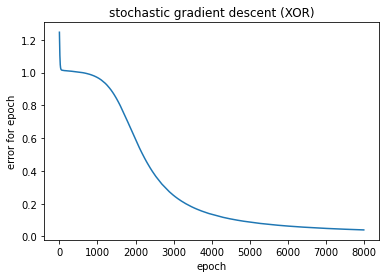

In [25]:
# New data D and labels y for xor
D = np.zeros((4,2),dtype=float)
D[0,:] = [0.,0.]
D[1,:] = [0.,1.]
D[2,:] = [1.,0.]
D[3,:] = [1.,1.]
D = torch.tensor(D,dtype=torch.float)
Y_xor = torch.tensor([0.,1.,1.,0.])
N = D.shape[0] # number of input patterns

# Initialize parameters
#     Although you will implement gradient descent manually, let's set requires_grad=True
#     anyway so PyTorch will track the gradient too, and we can compare your gradient with PyTorch's.
w_34 = torch.randn(2) # [size 2] tensor representing [w_3,w_4]
w_012 = torch.randn(3) # [size 3] tensor representing [w_0,w_1,w_2]
b_0 = torch.randn(1) # [size 1] tensor
b_1 = torch.randn(1) # [size 1] tensor
w_34.requires_grad=True
w_012.requires_grad=True
b_0.requires_grad=True
b_1.requires_grad=True

alpha = 0.05 # learning rate
nepochs = 8000 # number of epochs

track_error = []
verbose = True
for e in range(nepochs): # for each epoch
    error_epoch = 0. # sum loss across the epoch
    perm = np.random.permutation(N)
    for p in perm: # visit data points in random order
        x = D[p,:] # input pattern
        
        # Compute the output of hidden neuron h
        # e.g., two lines like the following
        net_h = torch.dot(x,w_34)+b_0
        h = g_logistic(net_h)
        # TODO : YOUR CODE GOES HERE
        #raise Exception('Replace with your code.')                  
        
        # Compute the output of neuron yhat
        # e.g., two lines like the following
        
        x_h = torch.cat((x,h))
        net_y = torch.dot(x_h,w_012)+b_1
        yhat = g_logistic(net_y)
        
        # TODO : YOUR CODE GOES HERE
        #raise Exception('Replace with your code.')                     
        
        # compute loss
        y = Y_xor[p]
        myloss = loss(yhat,y)
        error_epoch += myloss.item()
        
        # print output if this is the last epoch
        if (e == nepochs-1):
            print("Final result:")
            print_forward(x,yhat,y)
            print("")

        # Compute the gradient manually
        if verbose:
            print('Compute the gradient manually')
            print_forward(x,yhat,y)
        with torch.no_grad():
            # TODO : YOUR GRADIENT CODE GOES HERE
            #  should include at least these 4 lines (helper lines may be useful)
            w_34_grad = torch.tensor((  (2 * (yhat - y) * g_logistic(net_y) * (1 - g_logistic(net_y)) * w_012[2]) * (g_logistic(net_h) * (1 - g_logistic(net_h)) * x[0])   ,    (2 * (yhat - y) * g_logistic(net_y) * (1 - g_logistic(net_y)) * w_012[2]) * (g_logistic(net_h) * (1 - g_logistic(net_h)) * x[1])   ))                   
            b_0_grad =    (2 * (yhat - y) * g_logistic(net_y) * (1 - g_logistic(net_y)) * w_012[2]) * (g_logistic(net_h) * (1 - g_logistic(net_h)) * 1)
            
            w_012_grad = torch.tensor((  ( 2 * (yhat - y) * g_logistic(net_y) * (1 - g_logistic(net_y)) * x_h[0] )    ,   ( 2 * (yhat - y) * g_logistic(net_y) * (1 - g_logistic(net_y)) * x_h[1] )    ,     ( 2 * (yhat - y) * g_logistic(net_y) * (1 - g_logistic(net_y)) * x_h[2] )      ))
            b_1_grad = ( 2 * (yhat - y) * g_logistic(net_y) * (1 - g_logistic(net_y)) * 1 )

            
            #  make sure to inclose your code in the "with torch.no_grad()" wrapper,
            #   otherwise PyTorch will try to track the "gradient" of the gradient computation, which we don't want.
            #raise Exception('Replace with your code.')                      
        if verbose:
            print(" Grad for w_34 and b_0")
            print_grad(w_34_grad.numpy(),b_0_grad.numpy())
            print(" Grad for w_012 and b_1")
            print_grad(w_012_grad.numpy(),b_1_grad.numpy())
            print("")

        # Compute the gradient with PyTorch and compre with manual values
        if verbose: print('Compute the gradient using PyTorch .backward()')
        myloss.backward()
        if verbose:
            print(" Grad for w_34 and b_0")
            print_grad(w_34.grad.numpy(),b_0.grad.numpy())
            print(" Grad for w_012 and b_1")
            print_grad(w_012.grad.numpy(),b_1.grad.numpy())
            print("")
        w_34.grad.zero_() # clear PyTorch's gradient
        b_0.grad.zero_()
        w_012.grad.zero_()
        b_1.grad.zero_()
        
        # Parameter update with gradient descent
        with torch.no_grad():
            # TODO : YOUR PARAMETER UPDATE CODE GOES HERE
            # Four lines of the form
            w_34 -= w_34_grad * alpha
            b_0 -= b_0_grad * alpha
            w_012 -= w_012_grad * alpha
            b_1 -= b_1_grad * alpha
            #raise Exception('Replace with your code.')
            
    if verbose==True: verbose=False
    track_error.append(error_epoch)
    if e % 50 == 0:
        print("epoch " + str(e) + "; error=" +str(round(error_epoch,3)))
        print("w_34", w_34 )
        print("w_012", w_012 )
        print("b_0", b_0 )
        print("b_1", b_1 )
    
# track output of gradient descent
plt.figure()
plt.clf()
plt.plot(track_error)
plt.title('stochastic gradient descent (XOR)')
plt.ylabel('error for epoch')
plt.xlabel('epoch')
plt.show()

<div class="alert alert-success" role="alert">
<h3> Problem 5 (10 points) </h3>
<br>
After running your XOR network, print the values of the learned weights and biases. Your job now is to describe the solution that the network has learned. How does it work? Walk through each input pattern to describe how the network computes the right answer (if it does). See discussion in lecture for an example.
</div>

Answer: The network learned these weights and biases

In [26]:
print("w_34", w_34 )
print("w_012", w_012 )
print("b_0", b_0 )
print("b_1", b_1 )

w_34 tensor([ 7.2743, -6.5040], requires_grad=True)
w_012 tensor([ 4.7351, -4.3427, -9.7302], requires_grad=True)
b_0 tensor([3.3506], requires_grad=True)
b_1 tensor([7.0320], requires_grad=True)
